#### validation dataset generation   

In [1]:
import cv2
import torch
import numpy as np
from glob import glob
import rasterio as rio
from notebooks import config
from utils.img2patch import img2patch
from utils.imgShow import imsShow, imgShow


In [2]:
## we set base patch size to 512, the 256x256 is cropped from 512x512 patch
patch_size = 512  ## base patch size
higher_patch_size = 768
# patch_size_scales = [256, 512, 768, 1024, 1280]


In [6]:
# ## valset
paths_valset = list(zip(config.paths_scene_val, 
                        # config.paths_dem_val, 
                        config.paths_dem_adjust_val,
                        config.paths_truth_val))
paths_valset[4]


('data/dset/scene/l7_scene_04_nor.tif',
 'data/dset/dem/l7_scene_04_dem_adjust_nor.tif',
 'data/dset/truth/l7_scene_04.tif')

In [7]:
## generate validation patches (include patch,dem,truth)
dset_patch_list = []
dset_start_list = []
dset_list = {'patch':[], 'higher_patch':[]}       ## [patches, higher_patches]
for path_scene, path_dem, path_truth in paths_valset:
    scene_val_arr = rio.open(path_scene).read()   ## (C, H, W)
    truth_val_arr = rio.open(path_truth).read(1)
    dem_val_arr = rio.open(path_dem).read()
    size_global = scene_val_arr.shape[1:]
    ## image to patches
    scene_dem_truth_arr = np.concatenate([scene_val_arr, 
                                        dem_val_arr,
                                        # dem_adjust_val_arr, 
                                        truth_val_arr[np.newaxis, ...]], 
                                        axis=0)
    img2patches = img2patch(img = scene_dem_truth_arr.transpose(1,2,0), 
                            patch_size = patch_size, 
                            edge_overlay = 40,
                            drop_last=True)
    patch_dem_truth_list = img2patches.toPatch()
    higher_patch_dem_truth_list = img2patches.higher_patch_crop(higher_patch_size=higher_patch_size)
    print(len(patch_dem_truth_list))
    dset_list['patch'].extend(patch_dem_truth_list)
    dset_list['higher_patch'].extend(higher_patch_dem_truth_list)
    # break
print('num of patches:', len(dset_list['patch']))


9
9
9
16
9
9
16
9
9
16
9
9
9
121
9
9
16
num of patches: 293


In [ ]:
'''----  save multiscale patch data  ----'''
dir_valset = f'data/dset/valset/patch_{higher_patch_size}'
# dir_valset = f'data/dset/valset/patch_256'  ## lower_patch
# dir_valset = f'data/dset/valset/patch_512'  ## lower_patch
for id_patch, patch_pdem_ptruth in enumerate(dset_list['higher_patch']):
    print(id_patch)
    # low_patch_start = (512-256)//2  ## for 256x256 patch cropping from 512x512
    # patch_pdem_ptruth = patch_pdem_ptruth[low_patch_start:low_patch_start+256, low_patch_start:low_patch_start+256, :]
    ## save as float16 to save space
    patch_pdem_ptruth = torch.from_numpy(patch_pdem_ptruth).to(dtype=torch.float16)  
    path_save = dir_valset+f'/patch_pdem_ptruth_' + str(id_patch).rjust(4,'0')+'.pt'
    print(path_save)
    torch.save((patch_pdem_ptruth), path_save)
    # break 


0
data/dset/valset/patch_768/patch_pdem_ptruth_0000.pt


### load data and check

In [37]:
## load data
paths_valset_256 = sorted(glob('data/dset/valset/patch_256/*'))
paths_valset_512 = sorted(glob('data/dset/valset/patch_512/*'))
paths_valset_768 = sorted(glob('data/dset/valset/patch_768/*'))
paths_valset_1024 = sorted(glob('data/dset/valset/patch_1024/*'))
paths_valset_1280 = sorted(glob('data/dset/valset/patch_1280/*'))
valset_256_list = [torch.load(path, weights_only=True) for path in paths_valset_256]
valset_512_list = [torch.load(path, weights_only=True) for path in paths_valset_512]
valset_768_list = [torch.load(path, weights_only=True) for path in paths_valset_768]
valset_1024_list = [torch.load(path, weights_only=True) for path in paths_valset_1024]
valset_1280_list = [torch.load(path, weights_only=True) for path in paths_valset_1280]
valset_list = list(zip(valset_256_list, valset_512_list, valset_768_list, valset_1024_list, valset_1280_list))
print(len(valset_list))  


293


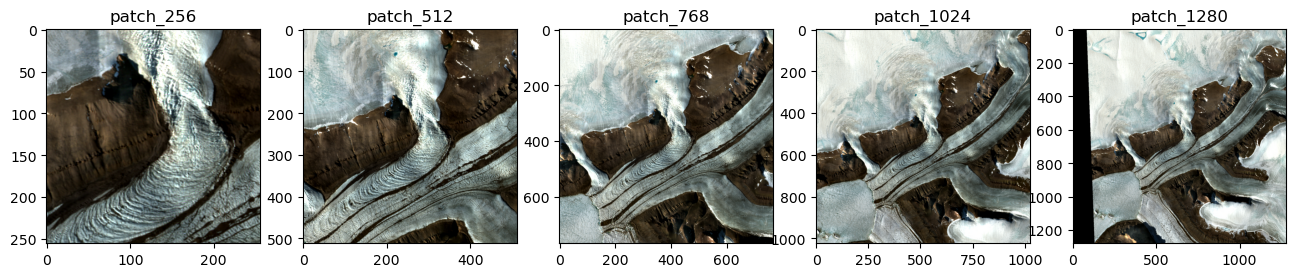

In [38]:
id = np.random.randint(0, len(valset_list))

patch_scales = [patch.numpy().astype(np.float32) for patch in valset_list[id]]
patch_256,patch_512,patch_768,patch_1024,patch_1280 = patch_scales

imgs_name = ['patch_256', 'patch_512', 'patch_768', 'patch_1024', 'patch_1280']  
clip_list = [2,2,2,2,2]  
col_bands_list = [(2,1,0), (2,1,0), (2,1,0), (2,1,0), (2,1,0)]
imsShow(img_list=[patch_256, patch_512, patch_768, patch_1024, patch_1280], 
            img_name_list=imgs_name,
            clip_list=clip_list, 
            color_bands_list=col_bands_list,
            figsize=(16,3))



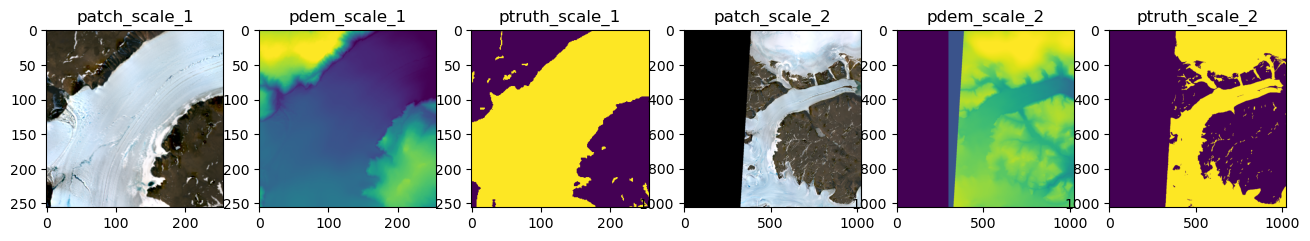

In [40]:
id = np.random.randint(0, len(valset_list))
patch_scales = [patch.numpy().astype(np.float32) for patch in valset_list[id]]

patch_scale_1 = patch_scales[0][:, :, 0:6]
pdem_scale_1 = patch_scales[0][:, :, 6:7]
ptruth_scale_1 = patch_scales[0][:, :, 7:8]

patch_scale_2 = patch_scales[3][:, :, 0:6]
pdem_scale_2 = patch_scales[3][:, :, 6:7]
ptruth_scale_2 = patch_scales[3][:, :, 7:8]

imgs_name = ['patch_scale_1', 'pdem_scale_1', 'ptruth_scale_1', 'patch_scale_2', 'pdem_scale_2', 'ptruth_scale_2']  
clip_list = [2,2,0,2,2,0]  
col_bands_list = [(2,1,0), (0,0,0), (0,0,0), (2,1,0), (0,0,0), (0,0,0)]
imsShow(img_list=[patch_scale_1, pdem_scale_1, ptruth_scale_1, 
                  patch_scale_2, pdem_scale_2, ptruth_scale_2], 
            img_name_list=imgs_name,
            clip_list=clip_list, 
            color_bands_list=col_bands_list,
            figsize=(16,3))
